In [6]:
import pandas as pd
import numpy as np

import logging

import dash
from dash.dependencies import Input, Output
import dash_html_components as html
import dash_core_components as dcc
# import modules & set up logging
import gensim
from gensim.models.doc2vec import TaggedDocument
import logging
#from pathlib import Path
import re
import string 
from itertools import islice
import multiprocessing
from gensim.models import Doc2Vec
import matplotlib.pylab as plt

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


# import modules & set up logging
from pathlib import Path
import string 

from sklearn.manifold import TSNE
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.plotly as py

import nltk
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
import re

import collections
import plotly
plotly.tools.set_credentials_file(username='albe88', api_key='FuLM7dUFVugZfDaWxk6O')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity



init_notebook_mode(connected=True)
% matplotlib inline

In [30]:
class Corpus2TaggedDocument(object):
    
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    def __iter__(self):
        ''' yield list of tokens for a single sentence in corpus '''
        for idx , line in enumerate(self.dataframe.text):
            document = line.lower()
            for sentence in self.sentencize(document):
                yield TaggedDocument(words=self.tokenize(sentence), tags=[str(idx)])
       
    def sentencize(self, text):
        return text.split('. ')
    
    def tokenize(self, text):
        return re.sub('([{}])'.format(string.punctuation), r' \1 ', text).split()
    
    def tokenize_only(self, text):
        # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
        tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
        filtered_tokens = []
        # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        for token in tokens:
            if re.search('[a-zA-Z]', re.sub('<\s*.*?>','',token)):
                filtered_tokens.append(token)
        return filtered_tokens
    
    def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', re.sub('<\s*.*?>','',token)):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems
    
    

In [5]:
df = pd.read_csv('interview_test.csv', header=None, names=['text'])

In [56]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', re.sub('<\s*.*?>','',token)):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', re.sub('<\s*.*?>','',token)):
            filtered_tokens.append(token)
    return filtered_tokens

In [6]:
sentences = Corpus2TaggedDocument(df)

In [7]:
for sentence in islice(sentences, 90): print sentence

TaggedDocument(['stick', 'blender', '-', 'free', 'online', 'funny', 'games', 'if', 'you', 'want', 'to', 'blow', 'milk', 'out', 'your', 'nose', ',', 'you', 'are', 'at', 'the', 'right', 'place'], ['0'])
TaggedDocument(['addictinggames', 'delivers', 'funny', 'games', 'in', 'massive', 'quantities'], ['0'])
TaggedDocument(['play', 'your', 'way', 'from', 'fart', 'jokes', 'straight', 'to', 'nauseatingly', 'snarky', 'robots', ',', 'and', 'laugh', 'yourself', 'stupid'], ['0'])
TaggedDocument(['feed', 'your', 'need', 'for', 'funny', 'games', '!', 'knock', 'a', 'loud', '-', 'mouth', 'jerk', 'as', 'far', 'as', 'you', 'can', 'in', 'homerun', 'in', 'berzerkland'], ['0'])
TaggedDocument(['eat', 'scuba', 'divers', 'in', 'shark', 'bait'], ['0'])
TaggedDocument(['see', 'if', 'you', 'can', 'think', 'your', 'way', 'through', 'i', 'dont', 'even', 'game'], ['0'])
TaggedDocument(['test', 'your', 'quiz', 'abilities', 'with', 'the', 'stupid', 'tests', ',', 'the', 'worlds', 'easyest', 'game', 'and', 'the', 'imp

In [8]:
cores = multiprocessing.cpu_count()

In [9]:
model = Doc2Vec(
    sentences,
    vector_size=100,
    min_count=2, 
    window=5,
    workers=cores
    )

In [10]:
model.save('./doc2vec.model')

## Model Evaluation

In [11]:
DATA_DIR = Path('./')
MODEL_PATH = DATA_DIR / 'doc2vec.model'

In [12]:
model = Doc2Vec.load('doc2vec.model')

In [79]:
df['doc_vectors'] = list(model.docvecs.vectors_docs)

In [80]:
df.head()

,text,doc_vectors
0,Stick Blender - Free Online Funny Games If you...,"[0.3313374, -0.20437007, -0.499616, 0.21268374..."
1,Blenders Review Why Use a Blender? The top per...,"[0.200803, 0.27143788, -0.5644821, 0.07569534,..."
2,Battle of the blenders: are the Nutribullet's ...,"[0.26537505, 0.30610573, -0.28650934, 0.370924..."
3,Top 5 blender and juicer deals The Blend-Activ...,"[-0.009851427, -0.018852755, -0.036894906, -0...."
4,Grain Free Granola Bars Have you been looking ...,"[0.36925697, 1.3718643, 0.025232743, 0.8107497..."


In [13]:
meta_records = []
for doc_id in model.docvecs.offset2doctag:
    d = dict()
    dff = df[df.index == int(doc_id)]
    d['tag'] = doc_id
    meta_records.append(d)

In [14]:
meta_df = pd.DataFrame.from_records(meta_records)

In [20]:
vect_rec = []
for doc in model.docvecs:
    doc_id = int(doc.offset2doctag)
    d = dict()
    dff = df[df.index == int(doc_id)]
    d['vec'] = doc.
    vect_rec.append(doc.get_vector)

SyntaxError: invalid syntax (<ipython-input-20-23145911014c>, line 6)

In [45]:
meta_df.tail()

,tag
995,995
996,996
997,997
998,998
999,999


In [15]:
masking = [str(i) for i in range(1000)]
top12_mask = meta_df.tag.isin(masking)

In [16]:
doc_vectors = model.docvecs.vectors_docs[top12_mask] 

In [44]:
from sklearn.cluster import KMeans

cluster_range = range(1,20)
cluster_errors = []

for num_clusters in cluster_range:
  clusters = KMeans( n_clusters=num_clusters)
  clusters.fit(doc_vectors) 
  cluster_errors.append( clusters.inertia_)

In [45]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors })

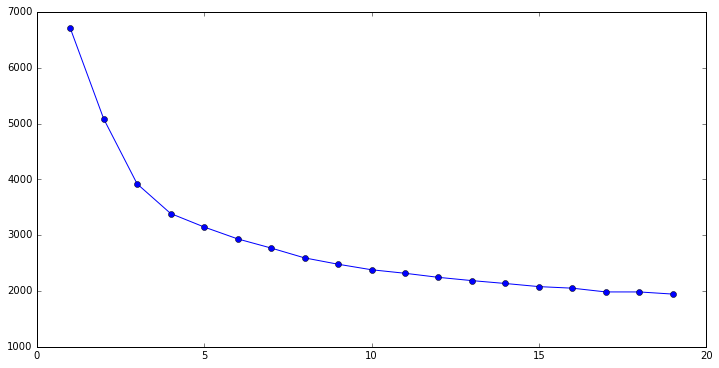

In [47]:
plt.figure(figsize=(12,6))
plt.plot(clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [48]:
all_documents = [text for text in df.text]

In [57]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in all_documents:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [58]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print '{} items in vocab_frame'.format(str(vocab_frame.shape[0]))

686846 items in vocab_frame


,words
stick,stick
blender,blender
free,free
onlin,online
funni,funny


In [60]:
num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(doc_vectors)

clusters = km.labels_.tolist()

CPU times: user 143 ms, sys: 13.8 ms, total: 157 ms
Wall time: 160 ms


In [62]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc2vec_cluster.pkl')

km = joblib.load('doc2vec_cluster.pkl')
clusters = km.labels_.tolist()

In [82]:
df['clusters'] = clusters

In [83]:
df2 = df[]

,text,doc_vectors,clusters
0,Stick Blender - Free Online Funny Games If you...,"[0.3313374, -0.20437007, -0.499616, 0.21268374...",0
1,Blenders Review Why Use a Blender? The top per...,"[0.200803, 0.27143788, -0.5644821, 0.07569534,...",4
2,Battle of the blenders: are the Nutribullet's ...,"[0.26537505, 0.30610573, -0.28650934, 0.370924...",4
3,Top 5 blender and juicer deals The Blend-Activ...,"[-0.009851427, -0.018852755, -0.036894906, -0....",0
4,Grain Free Granola Bars Have you been looking ...,"[0.36925697, 1.3718643, 0.025232743, 0.8107497...",3


In [63]:
films = { 'Text': all_documents, 'cluster': clusters}

frame = pd.DataFrame(films, index = [clusters] , columns = ['Text','cluster'])

In [64]:
frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)


0    495
4    262
1    102
3     85
2     56
Name: cluster, dtype: int64

In [71]:
#tokenize = lambda doc: doc.lower().split(" ")
sklearn_tfidf = TfidfVectorizer(norm='l2',stop_words=u'english', lowercase=True, min_df=0, use_idf=True, smooth_idf=False, sublinear_tf=True,ngram_range=(1,3), tokenizer=tokenize_and_stem)
sklearn_representation = sklearn_tfidf.fit_transform(all_documents)

In [72]:
vocab = np.array(sklearn_tfidf.get_feature_names())
results = np.array(sklearn_representation.toarray())

In [67]:
def get_KM_results(km, num_clusters, number_of_words = 10):
    print("Top terms per cluster:")
    print()
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    for i in range(num_clusters):
        print 'Cluster {} words:'.format(i)

        for ind in order_centroids[i, : number_of_words]: #replace 6 with n words per cluster
            #print('{}'.format(str(vocab_frame.ix[vocab[ind].split(' ')].values.tolist()[0][0]).encode('utf-8', 'ignore'), end=','))
            print(' %s' % str(vocab_frame.ix[vocab[ind].split(' ')].values.tolist()[0][0]).encode('utf-8', 'ignore'))
        print() #add whitespace
        print() #add whitespace
    print()
    print()

In [74]:
get_KM_results(km,5)

Top terms per cluster:
()
Cluster 0 words:
 'd
 'd
 'd
 'b
 'd
 'd
 'd
 'd
 'd
 'd
()
()
Cluster 1 words:
 'd
 'd
 'd
 'd
 'd
 'd
 'd
 'd
 'd
 'd
()
()
Cluster 2 words:
 'd
 'd
 'd
 'c
 'd
 'd
 'd
 'a
 'd
 'd
()
()
Cluster 3 words:
 'd
 'd
 'd
 'd
 'd
 'd
 'd
 'd
 'a
 'd
()
()
Cluster 4 words:
 'd
 'd
 'd
 'd
 'd
 'd
 'c
 'd
 'd
 'd
()
()
()
()


In [17]:
%%time
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(doc_vectors)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.008s...
[t-SNE] Computed neighbors for 1000 samples in 0.314s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.381309
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.466736
[t-SNE] Error after 500 iterations: 0.814829
CPU times: user 22 s, sys: 1.29 s, total: 23.3 s
Wall time: 23.9 s


In [18]:
traces = []
for tag_type in masking:
    trace = go.Scatter(
        x=tsne_results[meta_df.tag==tag_type,0],
        y=tsne_results[meta_df.tag==tag_type,1],
        mode='markers',
        name=tag_type, 
        marker=dict(
            size=10,
            opacity=0.5
        )
    )
    traces.append(trace)

layout = go.Layout(
    xaxis=dict(
    range = [-50, 50]
        ), 
    yaxis=dict(
    range = [-50, 50]
        )
    )

fig = go.Figure(data=traces, layout=layout)


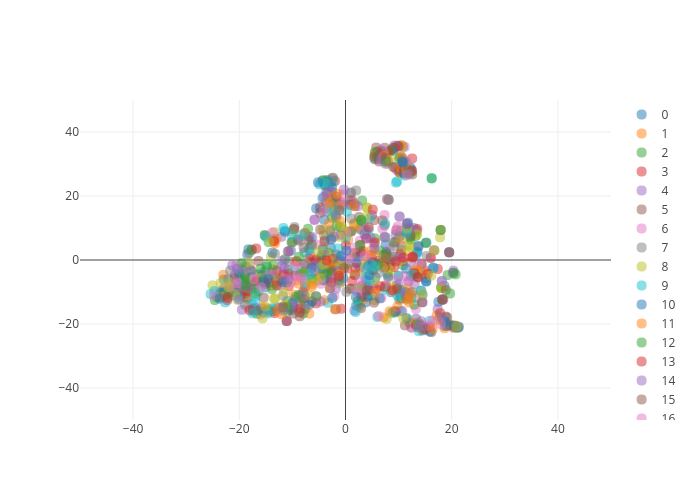

In [19]:
py.image.ishow(fig)